[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/nsga2_spea2.ipynb)

# Optimizing multiple objectives with NSGA2 & SPEA2 in Jax

This notebook shows how to use QDax to find diverse and performing parameters on a multi-objectives Rastrigin problem, using [NSGA2](https://ieeexplore.ieee.org/document/996017) and [SPEA2](https://www.semanticscholar.org/paper/SPEA2%3A-Improving-the-strength-pareto-evolutionary-Zitzler-Laumanns/b13724cb54ae4171916f3f969d304b9e9752a57f) algorithms. It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create an emitter instance
- how to create an NSGA2 instance
- how to create an SPEA2 instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process

In [1]:
import jax.numpy as jnp
import jax

from typing import Tuple

import matplotlib.pyplot as plt

from functools import partial

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex

try:
    import jumanji
except:
    !pip install "jumanji==0.2.2"
    import jumanji

try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.baselines.nsga2 import (
    NSGA2
)
from qdax.baselines.spea2 import (
    SPEA2
)

from qdax.core.emitters.mutation_operators import (
    polynomial_crossover, 
    polynomial_mutation
)
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.pareto_front import compute_pareto_front
from qdax.utils.plotting import plot_global_pareto_front

from qdax.utils.pareto_front import compute_pareto_front
from qdax.utils.plotting import plot_global_pareto_front
from qdax.utils.metrics import default_ga_metrics

from qdax.types import Genotype, Fitness, Descriptor

2025-11-19 00:32:32.876086: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/tin/anaconda3/envs/mix-me/lib/python3.10/site-packages/brax/v1/jumpy.py:34: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(
/home/tin/anaconda3/envs/mix-me/lib/python3.10/site-packages/brax/v1/__init__.py:26: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(


## Set the hyperparameters

In [2]:
#@markdown ---
population_size = 1000 #@param {type:"integer"}
num_iterations = 1000 #@param {type:"integer"}
proportion_mutation = 0.80 #@param {type:"number"}
minval = -5.12 #@param {type:"number"}
maxval = 5.12 #@param {type:"number"}
batch_size = 100 #@param {type:"integer"}
genotype_dim = 6 #@param {type:"integer"}
lag = 2.2 #@param {type:"number"}
base_lag = 0 #@param {type:"number"}
# for spea2
num_neighbours=1 #@param {type:"integer"}
#@markdown ---

## Define the scoring function: rastrigin multi-objective

We use two rastrigin functions with an offset to create a multi-objective problem.

In [3]:
def rastrigin_scorer(
    genotypes: jnp.ndarray, base_lag: float, lag: float
) -> Tuple[Fitness, Descriptor]:
    """
    Rastrigin Scorer with first two dimensions as descriptors
    """
    descriptors = genotypes[:, :2]
    f1 = -(
        10 * genotypes.shape[1]
        + jnp.sum(
            (genotypes - base_lag) ** 2
            - 10 * jnp.cos(2 * jnp.pi * (genotypes - base_lag)),
            axis=1,
        )
    )

    f2 = -(
        10 * genotypes.shape[1]
        + jnp.sum(
            (genotypes - lag) ** 2 - 10 * jnp.cos(2 * jnp.pi * (genotypes - lag)),
            axis=1,
        )
    )
    scores = jnp.stack([f1, f2], axis=-1)

    return scores, descriptors

In [4]:
# Scoring function
scoring_function = partial(
    rastrigin_scorer,
    lag=lag,
    base_lag=base_lag
)

def scoring_fn(x, random_key):
    return scoring_function(x)[0], {}, random_key

## Define initial population and emitter

In [5]:
# Initial population
random_key = jax.random.PRNGKey(0)
random_key, subkey = jax.random.split(random_key)
init_genotypes = jax.random.uniform(
    subkey, (batch_size, genotype_dim), minval=minval, maxval=maxval, dtype=jnp.float32
)

# Mutation & Crossover
crossover_function = partial(
    polynomial_crossover, 
    proportion_var_to_change=0.5,
)

mutation_function = partial(
    polynomial_mutation, 
    proportion_to_mutate=0.5, 
    eta=0.05, 
    minval=minval, 
    maxval=maxval
)

# Define the emitter
mixing_emitter = MixingEmitter(
    mutation_fn=mutation_function, 
    variation_fn=crossover_function, 
    variation_percentage=1-proportion_mutation, 
    batch_size=batch_size
)

## Instantiate and init NSGA2

In [6]:
# instantitiate nsga2
nsga2 = NSGA2(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=default_ga_metrics
)

# init nsga2
repertoire, emitter_state, random_key = nsga2.init(
    init_genotypes,
    population_size,
    random_key
)

## Run and visualize result

In [7]:
%%time

# run optimization loop
(repertoire, emitter_state, random_key), _ = jax.lax.scan(
    nsga2.scan_update, (repertoire, emitter_state, random_key), (), length=num_iterations
)

CPU times: user 1min 21s, sys: 1.1 s, total: 1min 22s
Wall time: 17.1 s


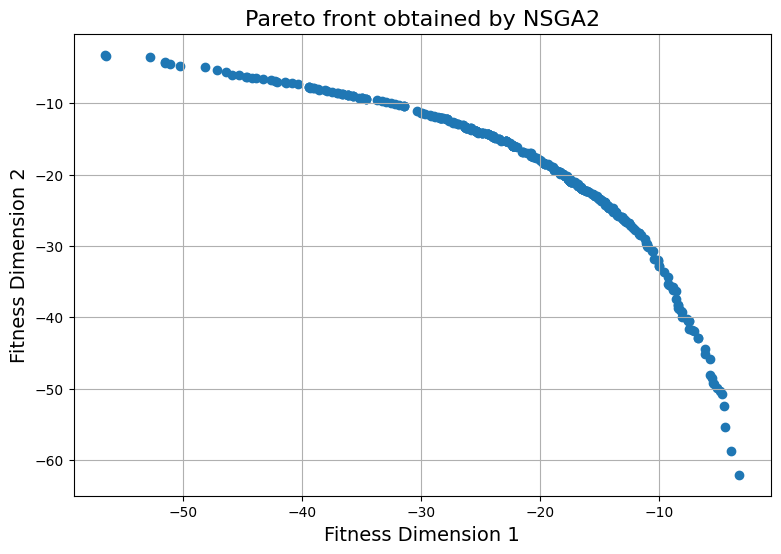

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(9, 6))
pareto_bool = compute_pareto_front(repertoire.fitnesses)
plot_global_pareto_front(repertoire.fitnesses[pareto_bool], ax=ax)
ax.set_title("Pareto front obtained by NSGA2", fontsize=16)
ax.set_xlabel("Fitness Dimension 1", fontsize=14)
ax.set_ylabel("Fitness Dimension 2", fontsize=14)
plt.grid()
plt.show()

## Instantiate and init SPEA2

In [9]:
# instantitiate spea2
spea2 = SPEA2(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=default_ga_metrics
)

# init spea2
repertoire, emitter_state, random_key = spea2.init(
    init_genotypes,
    population_size,
    num_neighbours,
    random_key
)

In [10]:
%%time

# run optimization loop
(repertoire, emitter_state, random_key), _ = jax.lax.scan(
    spea2.scan_update, (repertoire, emitter_state, random_key), (), length=num_iterations
)

CPU times: user 3.66 s, sys: 422 ms, total: 4.08 s
Wall time: 3.1 s


## Run and visualize result

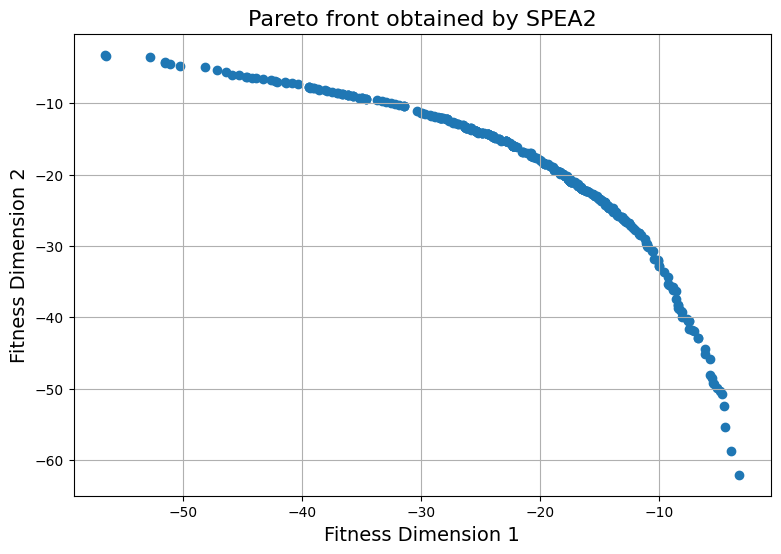

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(9, 6))
pareto_bool = compute_pareto_front(repertoire.fitnesses)
plot_global_pareto_front(repertoire.fitnesses[pareto_bool], ax=ax)
ax.set_title("Pareto front obtained by SPEA2", fontsize=16)
ax.set_xlabel("Fitness Dimension 1", fontsize=14)
ax.set_ylabel("Fitness Dimension 2", fontsize=14)
plt.grid()
plt.show()